In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv(r'dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')

In [9]:
df.groupby(['mes','ano'], observed=False).agg({'partos_e_nascimentos_qtd': 'sum'}).reset_index()

,mes,ano,partos_e_nascimentos_qtd
0,1,2009,105424.0
1,1,2010,103943.0
2,1,2011,98951.0
3,1,2012,92914.0
4,1,2013,94223.0
...,...,...,...
177,12,2019,80365.0
178,12,2020,75730.0
179,12,2021,78142.0
180,12,2022,75175.0


In [10]:
df['data'] = list(map(lambda x,y: "{}-{}".format(x,y), df['ano'], df['mes']))

In [11]:
def convert_to_datetime(data):
    return datetime.strptime(data, format("%Y-%m"))

In [12]:
df['time'] = list(map(lambda x: convert_to_datetime(x), df['data']))

In [13]:
df_st = df.groupby(['time']).agg({'partos_e_nascimentos_qtd': 'sum',
                                  'partos_e_nascimentos_val':'sum',
                                  'cirurgias_obstetricas_qtd': 'sum',
                                  'cirurgias_obstetricas_val': 'sum'})

In [14]:
df_st = df_st['2009-01-01':'2023-12-01']

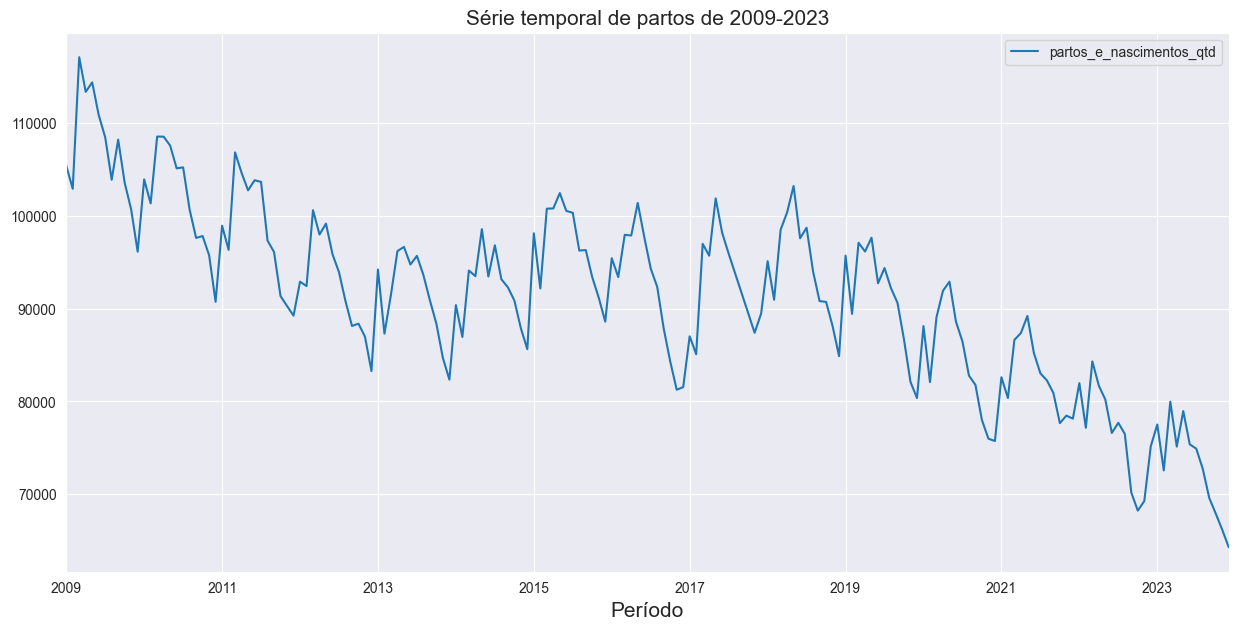

In [15]:
df_st['partos_e_nascimentos_qtd'].plot(figsize=(15,7), legend=True)
plt.xlabel('Período',size=15)
plt.title('Série temporal de partos de 2009-2023',size=15);

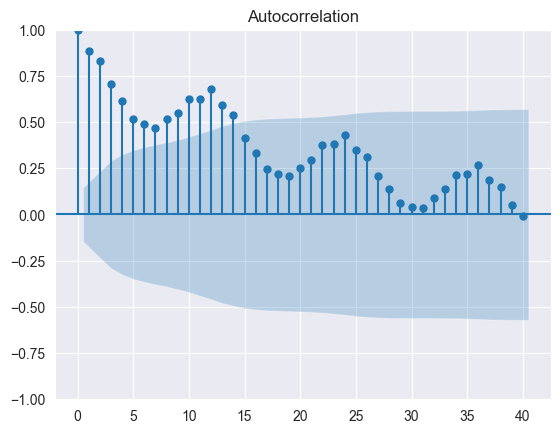

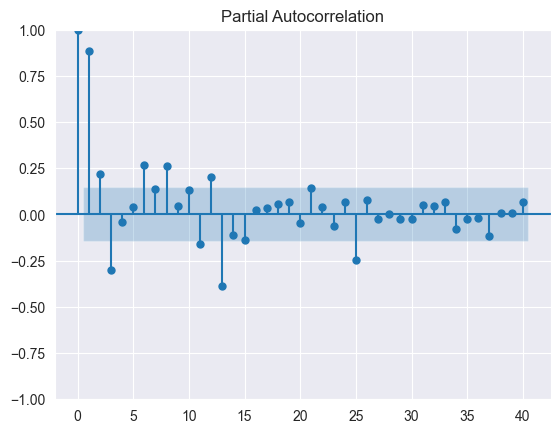

In [16]:
plot_acf(df_st.partos_e_nascimentos_qtd, lags=40)
plot_pacf(df_st.partos_e_nascimentos_qtd, lags=40)
plt.show()

In [17]:
model = auto_arima(df_st['partos_e_nascimentos_qtd'],
                   d=2, #max_d=2, test = 'adf',
                   start_p=0, max_p=6,
                   start_q=0, max_q=6,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True,
                   seasonal=True,
                   m=12,
                   start_P=0, max_P=2,
                   start_Q=0, max_Q=2,
                   D=2
                   )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=3207.016, Time=0.09 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=3102.884, Time=0.23 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=3157.079, Time=0.05 sec
 ARIMA(1,2,0)(2,2,0)[12]             : AIC=3090.363, Time=0.85 sec
 ARIMA(1,2,0)(2,2,1)[12]             : AIC=3046.857, Time=0.80 sec
 ARIMA(1,2,0)(1,2,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(1,2,0)(2,2,2)[12]             : AIC=3045.369, Time=1.11 sec
 ARIMA(1,2,0)(1,2,2)[12]             : AIC=inf, Time=2.12 sec
 ARIMA(0,2,0)(2,2,2)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(2,2,0)(2,2,2)[12]             : AIC=inf, Time=2.43 sec
 ARIMA(1,2,1)(2,2,2)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,2,1)(2,2,2)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(2,2,1)(2,2,2)[12]             : AIC=2979.792, Time=2.60 sec
 ARIMA(2,2,1)(1,2,2)[12]             : AIC=inf, Time=2

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  180
Model:             SARIMAX(2, 2, 1)x(2, 2, [1, 2], 12)   Log Likelihood               -1481.896
Date:                                 Tue, 25 Jun 2024   AIC                           2979.792
Time:                                         15:13:26   BIC                           3004.087
Sample:                                     01-01-2009   HQIC                          2989.661
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3449      0.310     -1.113      0.266      -0.952       0.263
ar.L2         -0.2087      0.277     -0.752      0.452      -0.752       0.335
ma.L1         -0.7037      0.232     -3.037      0.002      -1.158      -0.250
ar.S.L12      -1.0308      0.567     -1.817      0.069      -2.143       0.081
ar.S.L24      -0.1273      0.187     -0.682      0.495      -0.493       0.239
ma.S.L12       0.0049      0.594      0.008      0.993      -1.158       1.168
ma.S.L24      -0.7452      0.472     -1.580      0.114      -1.669       0.179
sigma2       2.44e+07   8.64e-09   2.82e+15      0.000    2.44e+07    2.44e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.46   Prob(JB):                         0.70
Heteroskedasticity (H):               0.79   Skew:                            -0.16
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.69e+31. Standard errors may be unstable.
"""

In [20]:
model_ = auto_arima(df_st['partos_e_nascimentos_qtd'],
                   d=2, #max_d=2, test = 'adf',
                   start_p=0, max_p=6,
                   start_q=0, max_q=6,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=False,
                   seasonal=True,
                   m=12,
                   start_P=0, max_P=2,
                   start_Q=0, max_Q=2,
                   D=2
                   )

 ARIMA(0,2,0)(0,2,0)[12]             : AIC=3207.016, Time=0.04 sec
 ARIMA(0,2,0)(0,2,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,0)(0,2,2)[12]             : AIC=3053.105, Time=0.72 sec
 ARIMA(0,2,0)(1,2,0)[12]             : AIC=3147.927, Time=0.62 sec
 ARIMA(0,2,0)(1,2,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,2,0)(1,2,2)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,2,0)(2,2,0)[12]             : AIC=3143.191, Time=0.34 sec
 ARIMA(0,2,0)(2,2,1)[12]             : AIC=3031.772, Time=0.48 sec
 ARIMA(0,2,0)(2,2,2)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,2,1)(0,2,0)[12]             : AIC=3102.923, Time=0.07 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,2,1)(0,2,2)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,2,1)(1,2,0)[12]             : AIC=3047.637, Time=0.46 sec
 ARIMA(0,2,1)(1,2,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,2,1)(1,2,2)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(0,2,1)(2,2,0)[12]           

In [21]:
model_.aic()

3025.917589016053

In [68]:
model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  168
Model:             SARIMAX(2, 2, 1)x(2, 2, [], 12)   Log Likelihood               -1386.577
Date:                             Sun, 23 Jun 2024   AIC                           2785.154
Time:                                     22:47:22   BIC                           2802.889
Sample:                                 01-01-2009   HQIC                          2792.361
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5334      0.125     -4.283      0.000      -0.778      -0.289
ar.L2         -0.3376      0.124     -2.717      0.007      -0.581      -0.094
ma.L1         -0.5388      0.125     -4.311      0.000      -0.784      -0.294
ar.S.L12      -0.6243      0.032    -19.630      0.000      -0.687      -0.562
ar.S.L24      -0.2262      0.018    -12.297      0.000      -0.262      -0.190
sigma2      2.173e+07   1.67e-09    1.3e+16      0.000    2.17e+07    2.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               178.42
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+32. Standard errors may be unstable.
"""

In [28]:
treino = df_st['partos_e_nascimentos_qtd'].loc[:'2022-12-01']
teste = df_st['partos_e_nascimentos_qtd'].loc['2023-01-01':]
print(treino.shape[0])
print(teste.shape[0])

168
12


In [29]:
# treinar os modelos
model.fit(treino)

ARIMA(order=(2, 2, 1), scoring_args={}, seasonal_order=(2, 2, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [30]:
model_.fit(treino)

ARIMA(order=(2, 2, 1), scoring_args={}, seasonal_order=(2, 2, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [31]:
# gerar previsões para cada modelo
forecast = model.predict(n_periods = 12)
forecast_ = model_.predict(n_periods = 12)

In [32]:
df_forecast = pd.DataFrame(forecast, index=teste.index, columns=['predicao_model_1'])
df_forecast_ = pd.DataFrame(forecast_, index=teste.index, columns=['predicao_model_2'])

In [33]:
df_forecast.head()

,predicao_model_1
time,
2023-01-01,79632.681496
2023-02-01,75390.785188
2023-03-01,84247.089058
2023-04-01,82536.327863
2023-05-01,82047.753815


In [34]:
df_forecast_.head()

,predicao_model_2
time,
2023-01-01,75798.846206
2023-02-01,71687.019243
2023-03-01,80389.443815
2023-04-01,76966.929789
2023-05-01,75007.915513


<Figure size 2000x500 with 0 Axes>

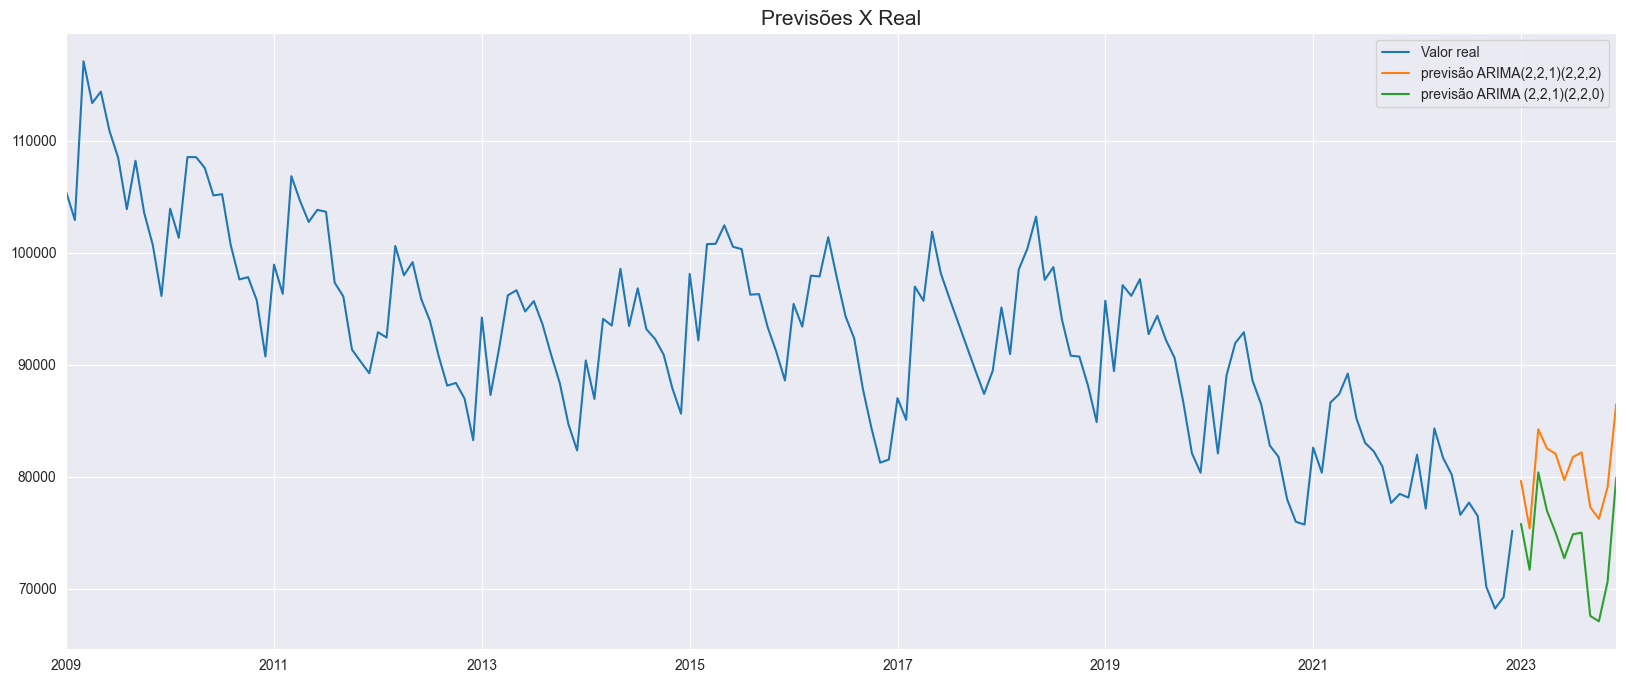

In [35]:
plt.figure(figsize=(20,5))
pd.concat([treino, df_forecast, df_forecast_],axis=1).plot(figsize=(20,8))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','previsão ARIMA(2,2,1)(2,2,2)','previsão ARIMA (2,2,1)(2,2,0)'])
plt.show()

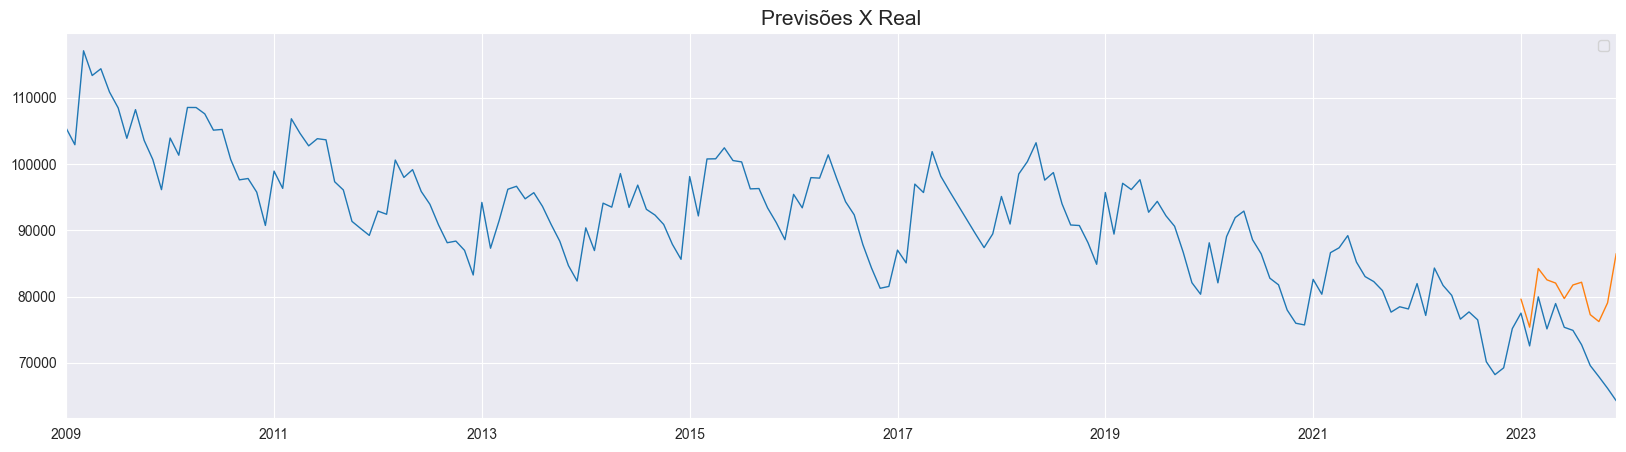

In [36]:
pd.concat([df_st.partos_e_nascimentos_qtd, forecast],axis=1).plot(linewidth=1,figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

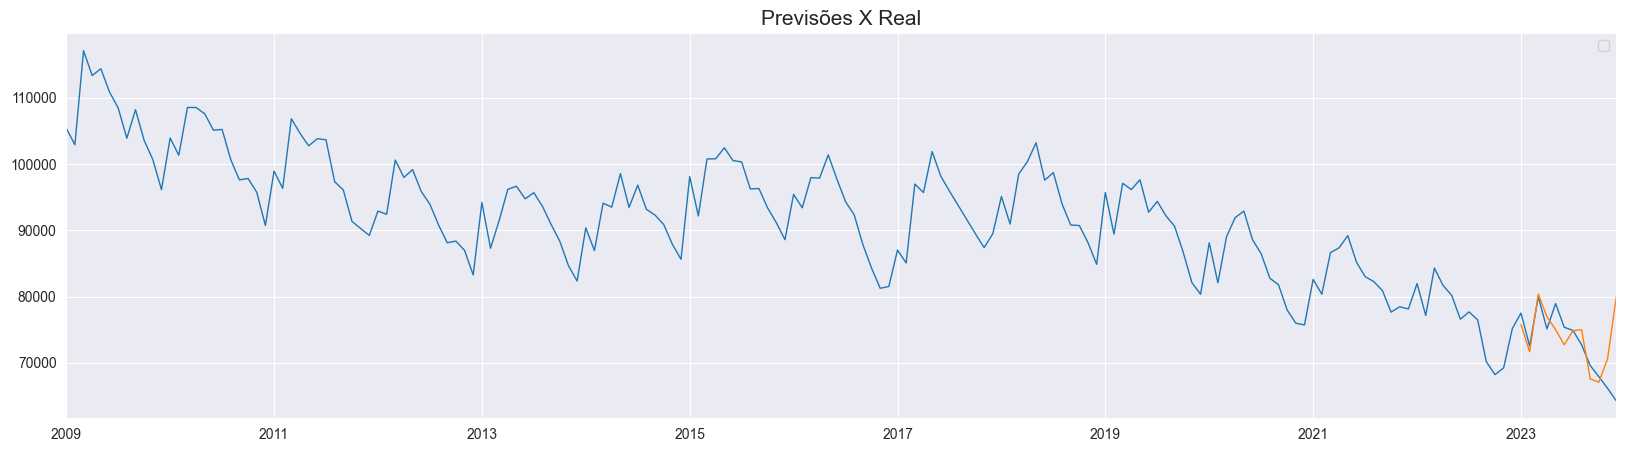

In [37]:
pd.concat([df_st.partos_e_nascimentos_qtd, forecast_],axis=1).plot(linewidth=1, figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

#### Análise de Resíduos
##### Uma das principais etapas é a avaliação dos resíduos. Primeiramente vamos olhar o rmse que é umas das principais métricas para análise dos erros, onde ele compara valores reais com os preditos. Aqui é interessante que o resultado seja o mais próximo possível de zero.

In [38]:
from sklearn.metrics import mean_squared_error

print("RMSE do modelo 1: %.3f" % np.sqrt(mean_squared_error(teste, forecast)))
print('')
print("RMSE do modelo 2: %.3f" % np.sqrt(mean_squared_error(teste, forecast_)))

RMSE do modelo 1: 9303.562

RMSE do modelo 2: 5036.860


In [39]:
# Calculando os erros
erros = pd.DataFrame(np.array(forecast.values.tolist()) - np.array(teste.values.tolist()))
erros_ = pd.DataFrame(np.array(forecast_.values.tolist()) - np.array(teste.values.tolist()))

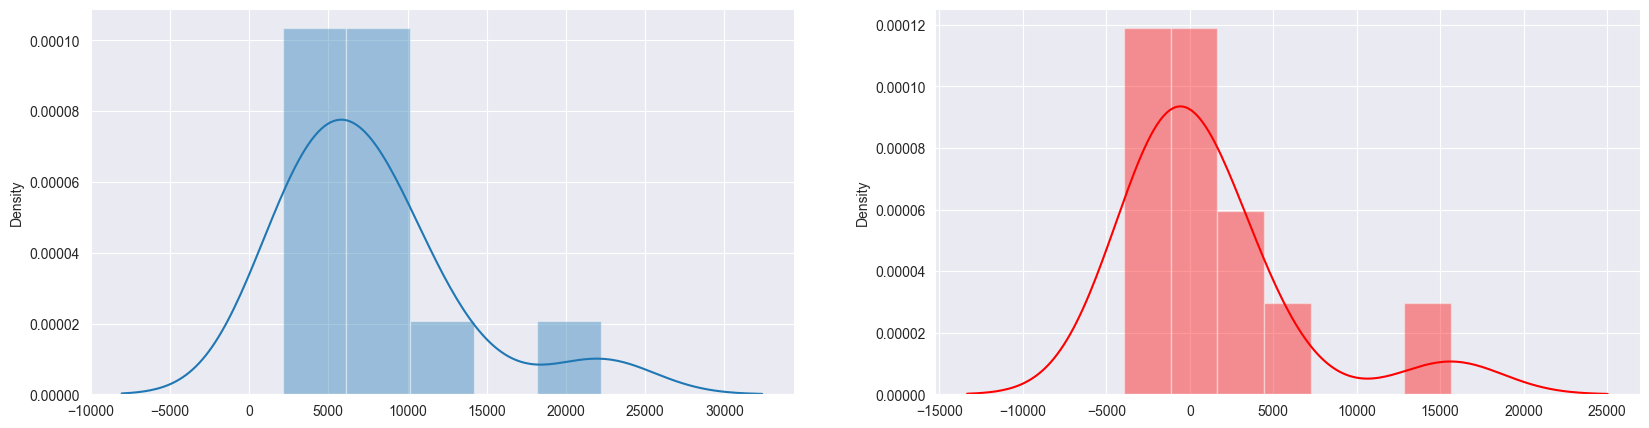

In [40]:
# Vamos ver graficamente a distribuião dos resíduos dos modelos: são bem semelhantes e se assemelham com uma distribuição normal.

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(erros,ax=ax[0])
sns.distplot(erros_,ax=ax[1], color='red');

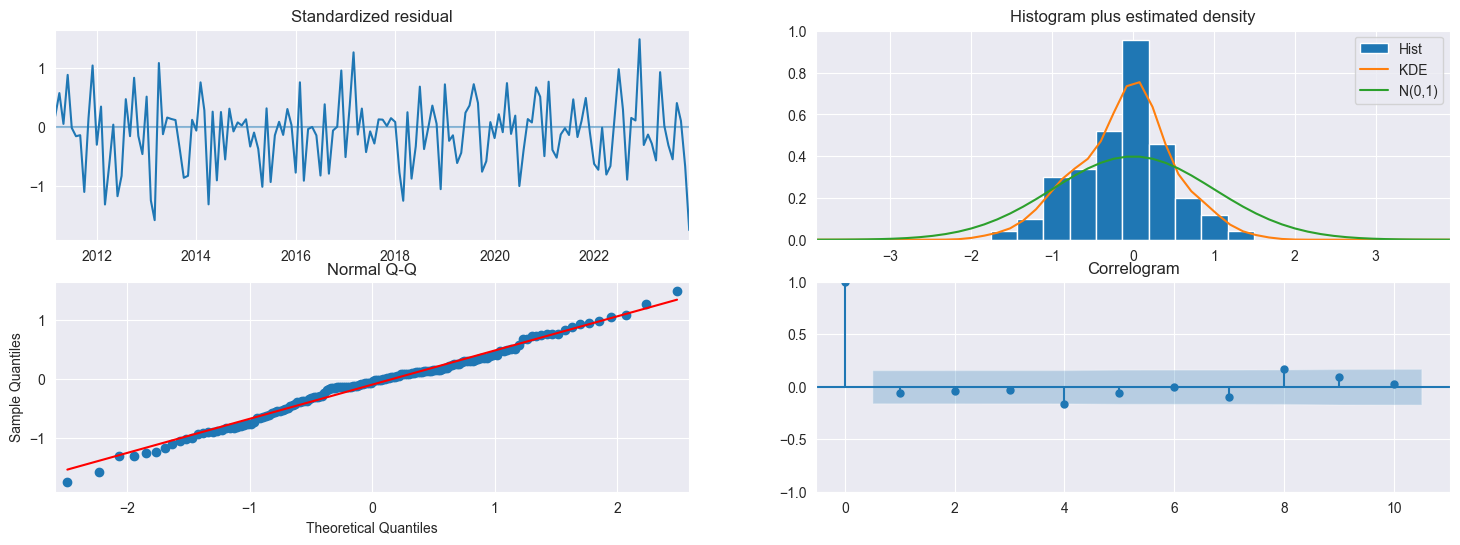

In [22]:
## Avaliando cada modelo com QQ-plot
model.plot_diagnostics(figsize=(18, 6))
plt.show()

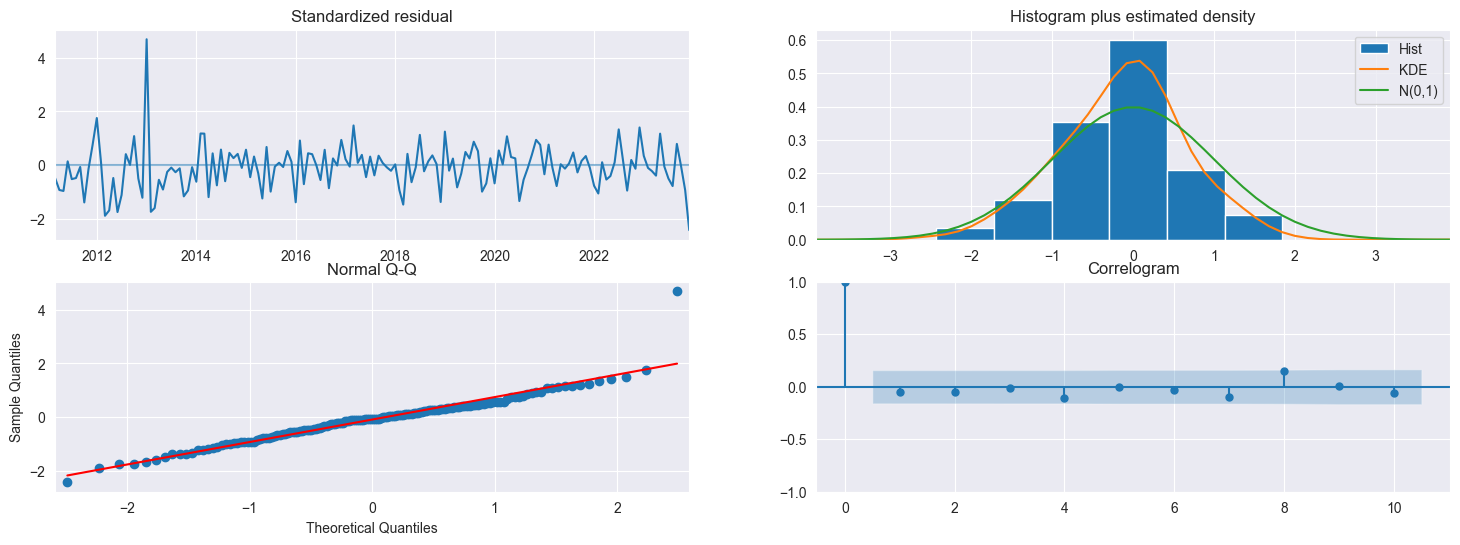

In [24]:
model_.plot_diagnostics(figsize=(18, 6))
plt.show()

In [41]:
# Teste de normalidade resíduos
test = jarque_bera(erros)
print('Estatística Jarque-Bera :', test[0])
print('p-valor :', test[1])
print('Assimetria :', test[2])
print('Curtose :',test[3])

Estatística Jarque-Bera : [6.77057479]
p-valor : [0.03386791]
Assimetria : [1.5505462]
Curtose : [4.98100365]


In [42]:
test_ = jarque_bera(erros_)
print('Estatística Jarque-Bera :', test_[0])
print('p-valor :', test_[1])
print('Assimetria :', test_[2])
print('Curtose :',test_[3])

Estatística Jarque-Bera : [14.66442035]
p-valor : [0.00065413]
Assimetria : [2.03012621]
Curtose : [6.5837398]


In [43]:
previsao_meses = model_.predict(n_periods=12)

In [44]:
df_proximos_meses = pd.DataFrame(previsao_meses.values, index=pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS'), columns=['nova_previsao'])

In [45]:
#df_proximos_meses['nova_previsao'] = df_proximos_meses['nova_previsao'] + 10000

<Figure size 2000x500 with 0 Axes>

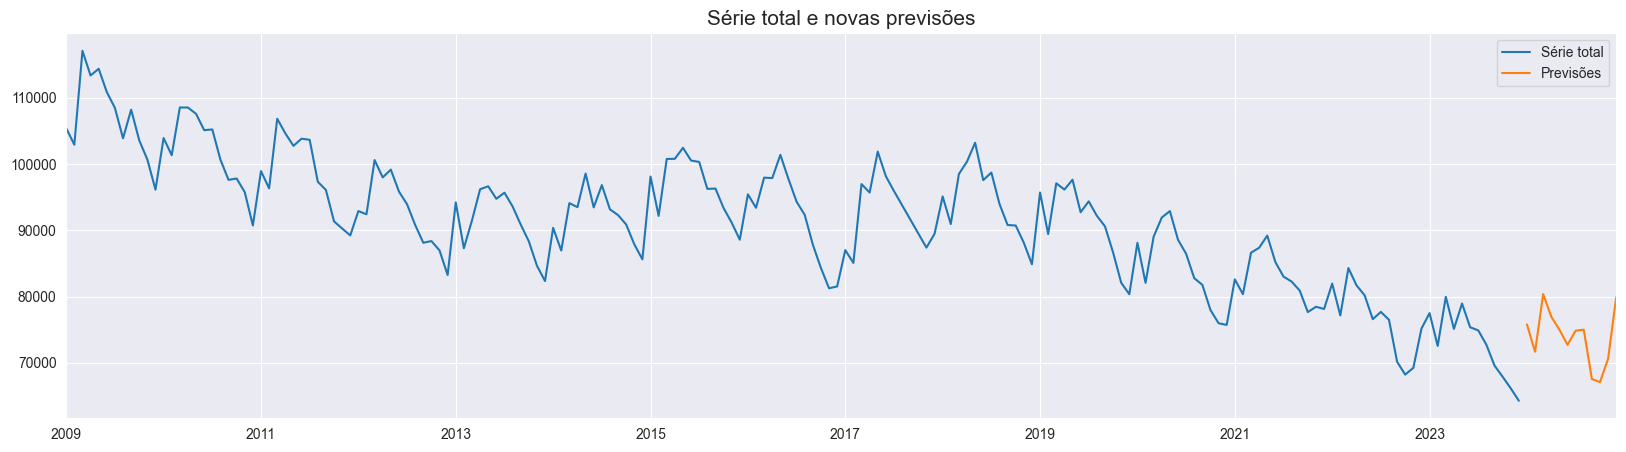

In [46]:
plt.figure(figsize=(20,5))
pd.concat([df_st.partos_e_nascimentos_qtd, df_proximos_meses],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e novas previsões',size=15)
plt.legend(['Série total','Previsões'])
plt.show()

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
arima_best = SARIMAX(treino, order=(2,2,1), seasonal_order=(2,2,2,12)).fit(disp=0)

In [50]:
predito_best = arima_best.predict(typ='levels')

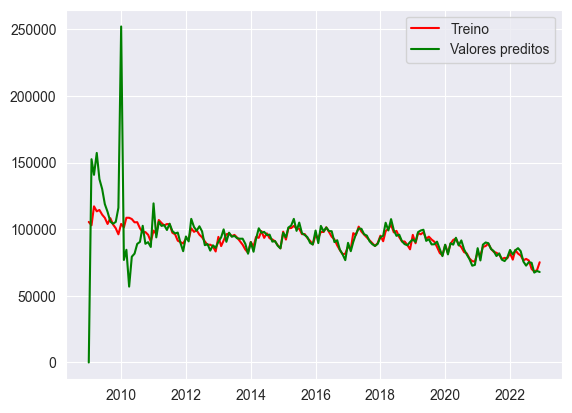

In [51]:
plt.plot(treino, color='red')   
plt.plot(predito_best, color='green')
plt.legend(['Treino','Valores preditos']);